# Segmentando clientes

En esta notebook se verá una forma sobre como segmentar a los clientes, cuando cuenta con una gran cantidad de estos sobre una base de datos de una gran (?) cantidad de dimensiones.

Empezaremos cargando el entorno e instalando los requerimentos necesarios.

In [4]:
#%pip install scikit-learn==1.3.2
#%pip install seaborn==0.13.1
#%pip install numpy==1.26.4
#%pip install matplotlib==3.7.1
%pip install umap
%pip install umap-learn


Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer

In [ ]:
""""base_path = '/content/drive/MyDrive/DMEyF/2024/'
dataset_path = base_path + 'datos/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_01.csv'""""

In [ ]:
#df=pd.read_csv(r"C:\Users\maria\competencia_ternaria_010k.csv")

In [6]:
df_train = pd.read_csv(r"C:\Users\maria\competencia_ternaria_010k.csv")

Solo segmentaremos a los clientes de abril, dado que necesitaremos variables en algún momento agregar variables históricas para entender su comportamiento previo a la **baja**

In [8]:
df_train = pd.read_csv(r"C:\Users\maria\competencia_01_col1.csv")

In [10]:
df_train = df_train[df_train['foto_mes']==202104]

A su vez, nos concentraremos en el fenómeno de la **baja**. No importa si es en un mes o si es en dos.

In [12]:
Xtrain = df_train
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)
Xtrain = Xtrain.drop("clase_ternaria", axis=1)

del(df_train)

Lo primero que necesitamos es saber cuando un cliente es parecido a otro. Todos los clientes que son parecidos los juntaremos en un **segmento** y sobre esos segmentos haremos perfilados o profiles para entender que los caracteriza.

Saber cuando un cliente es parecido a otro no es algo tan simple en un problema de alta dimensionalidad, lo que se suele llamar **curse of dimensionality**. Las cosas no son lo mismo más allá de nuestras 3 escasas dimensiones. Para muestra, un botón: https://www.youtube.com/watch?v=mceaM2_zQd8

Por esto, es conveniente usar herramientas que nos ayuden a no tener que hacer distancias euclídeas.

Empecemos con una ayuda con nos dan nuestros amigos, los **rf** con una original matriz de distancias (https://en.wikipedia.org/wiki/Distance_matrix)

La **Random Forest Distance** es una matriz derivada del algoritmo Random Forest,

+ Se utiliza para medir la similitud entre pares de puntos de datos. Esta métrica se basa en la idea de cuántas veces dos puntos de datos terminan en la misma hoja de un árbol en un **rf**, entre los múltiples árboles que se generan.

+ Cómo se Calcula?

 1. Se entrena un **rf**.
 2. Para cada par de clientes $c_i$ y $c_j$, se observa cuántas veces caen en la misma hoja a través de todos los árboles del bosque. Luego se agrega en la posición $i$, $j$ de una matriz el número de veces que coincidieron esos dos clientes en un nodo terminal.
 3. Se calcula la matriz de distancia como **1 - proporción de veces que caen en la misma hoja**. Ejemplo: Si caen en la misma hoja el 90% de las veces, su distancia será 0.1. Si nunca caen en la misma hoja, la distancia es 1.

Veamoslo aplicado en nuestro caso

Para trabajar con este algoritmo no vamos a trabajar con todos los datos. Usted decida con cuantos trabajar. En este caso, tomaremos todos los **baja** y unos 2000 **continua**, ya que queremos como interactuan los segmentos de clientes que se van con los que se quedan.


In [14]:
np.random.seed(17)
continua_sample = ytrain[ytrain == 0].sample(2000).index
bajas_1_2 = ytrain[ytrain == 1].index
rf_index = continua_sample.union(bajas_1_2)

Xtrain_rf = Xtrain.loc[rf_index]
ytrain_rf = ytrain.loc[rf_index]

Entrenamos un simple **rf**, despliegue sus herramientas aprendidas para contar con un buen modelo


In [16]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
Xtrain_rf_imp = imp_mean.fit_transform(Xtrain_rf)

model = RandomForestClassifier(n_estimators=100, max_features=20, min_samples_leaf=400, random_state=17 )
model.fit(Xtrain_rf_imp, ytrain_rf)

RandomForestClassifier(max_features=20, min_samples_leaf=400, random_state=17)

Armamos (copiamos de internet) una función que nos calcule la matriz de distancias

In [18]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat

md = distanceMatrix(model, Xtrain_rf_imp)

Veamos como se ve. Recuerde que significa que un número esté cerca de 0 o que esté cerca de 1.

In [20]:
md

array([[0.  , 0.49, 0.96, ..., 0.87, 0.87, 0.8 ],
       [0.49, 0.  , 0.92, ..., 0.95, 0.95, 0.88],
       [0.96, 0.92, 0.  , ..., 0.61, 0.61, 0.95],
       ...,
       [0.87, 0.95, 0.61, ..., 0.  , 0.07, 0.42],
       [0.87, 0.95, 0.61, ..., 0.07, 0.  , 0.39],
       [0.8 , 0.88, 0.95, ..., 0.42, 0.39, 0.  ]])

Para poder visualizar la matriz, utilizaremos un embedding. Los *embeddings* son representaciones vectoriales de datos en un espacio de menor dimensión

Podría utilizar un **PCA** con ese fin, pero en los últimos años hay mejores algoritmos como **t-sne** o **umap**.

UMAP (Uniform Manifold Approximation and Projection) es una técnica avanzada para la reducción de dimensionalidad y visualización de datos en espacios de menor dimensión, que busca mantener al máximo la estructura de los datos en alta dimensión.

1. **Preservación de la Estructura Global y Local**:
   - Intenta preservar tanto la estructura local (relaciones cercanas) como la global (estructura general) de los datos al proyectarlos en un espacio de menor dimensión.

2. **Basado en Manifold Learning**:
   - UMAP asume que los datos de alta dimensión se encuentran en un espacio de menor dimensión (un "manifold") y busca proyectar esos datos de manera que se mantenga esa estructura subyacente.

3. **Velocidad y Escalabilidad**:
   - UMAP es más rápido y escalable en comparación con técnicas similares como t-SNE, especialmente en conjuntos de datos grandes.

4. **Control sobre la Estructura**:
   - UMAP permite al usuario ajustar parámetros que controlan la preservación de la estructura local y global, como el número de vecinos cercanos (n_neighbors) y la distancia mínima entre puntos (min_dist).

Una característica adicional, es que cuenta con la posibilidad de recibir de entrada una matriz de distancia.

Veamos los datos por primera vez:

C:\Users\maria\anaconda3\Lib\site-packages\umap\umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
C:\Users\maria\anaconda3\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


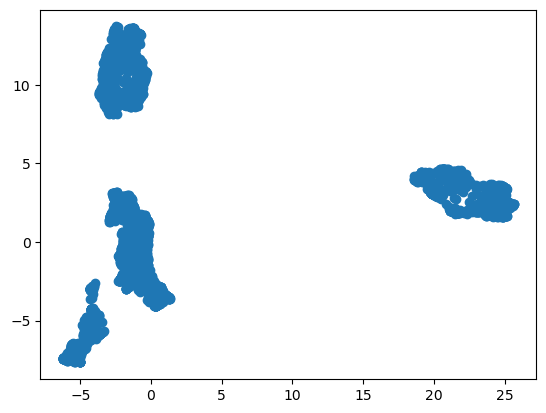

In [22]:
embedding_rf = UMAP(
  n_components=2,
  n_neighbors=50,
  metric="precomputed",
  random_state=17,
).fit_transform(md)

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

Agreguemos la dimensión de la probabilidad de salida, para ver donde cree el modelo que se encuentran los **bajas**.

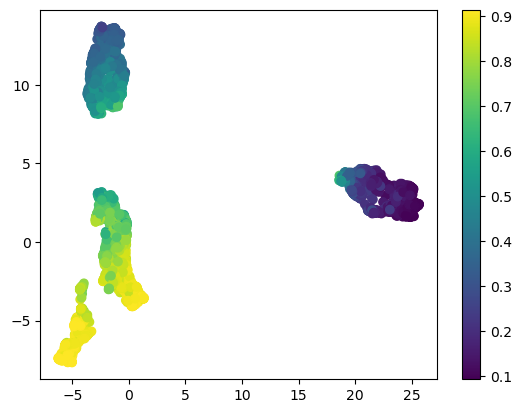

In [24]:
class_index = np.where(model.classes_ == 1)[0]
prob_baja = model.predict_proba(Xtrain_rf_imp)[:,class_index]

plt.scatter(embedding_rf[:,0], embedding_rf[:,1], c=prob_baja)
plt.colorbar()
plt.show()

Vamos a partir de este embedding para segmentar a los clientes. Puede utilizar cualquier técnica, los datos ya son simples para cualquier algoritmo. Utilizaremos uno bastante estandar

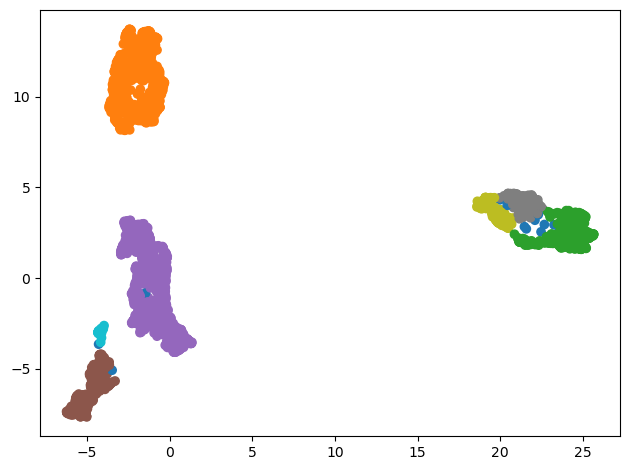

In [26]:
hdb = DBSCAN(eps=0.3)
y = hdb.fit(embedding_rf)

plt.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=y.labels_, cmap='tab10')
plt.tight_layout()
plt.show()

Veamos cuantos cluster detecto y cuantos clientes tiene cada uno

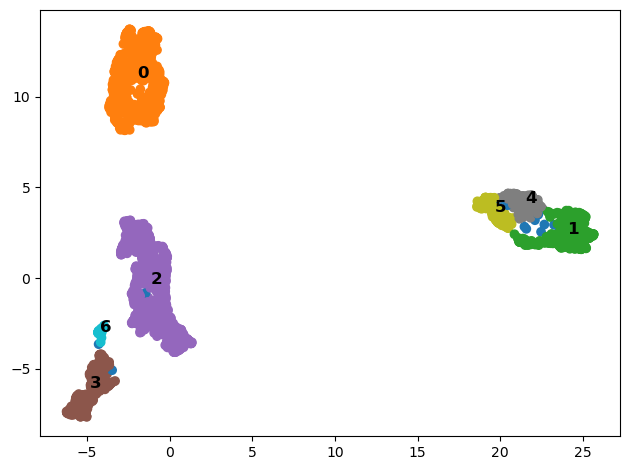

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN

# Ajuste del modelo DBSCAN
hdb = DBSCAN(eps=0.3)
y = hdb.fit(embedding_rf)

# Crear scatter plot
plt.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=y.labels_, cmap='tab10')

# Encontrar los clusters únicos (excluyendo el ruido con -1)
unique_labels = np.unique(y.labels_)
for label in unique_labels:
    if label != -1:  # Excluir ruido
        # Filtrar puntos pertenecientes al clúster actual
        cluster_points = embedding_rf[y.labels_ == label]
        # Calcular el centroide del clúster (media de las coordenadas)
        centroid = cluster_points.mean(axis=0)
        # Agregar la etiqueta en el centro del clúster
        plt.text(centroid[0], centroid[1], str(label), fontsize=12, fontweight='bold', color='black')

plt.tight_layout()
plt.show()



In [30]:
# Filtrar las filas que pertenecen al clúster 0
cluster_0_data = embedding_rf[y.labels_ == 0]

# Mostrar las filas del clúster 0
print(cluster_0_data)


[[-2.70156    9.219989 ]
 [-2.6307492 11.137413 ]
 [-3.6438766  9.52746  ]
 ...
 [-1.2185761  9.169609 ]
 [-0.8141742  9.32014  ]
 [-1.222003   9.239116 ]]


In [32]:
import numpy as np

# Obtener el número total de clusters detectados (excluyendo el ruido con etiqueta -1)
n_clusters = len(set(y.labels_)) - (1 if -1 in y.labels_ else 0)

# Iterar sobre cada clúster detectado
for cluster in range(n_clusters):
    # Obtener los índices de los datos que pertenecen al clúster actual
    cluster_indices = np.where(y.labels_ == cluster)
    
    # Filtrar los datos del clúster
    cluster_data = embedding_rf[cluster_indices]
    
    print(f"Datos del clúster {cluster}:")
    print(cluster_data)
    print("\n")


Datos del clúster 0:
[[-2.70156    9.219989 ]
 [-2.6307492 11.137413 ]
 [-3.6438766  9.52746  ]
 ...
 [-1.2185761  9.169609 ]
 [-0.8141742  9.32014  ]
 [-1.222003   9.239116 ]]


Datos del clúster 1:
[[23.893135   2.4799807]
 [21.083145   2.1804929]
 [21.639566   1.893876 ]
 ...
 [24.850353   2.9773264]
 [25.280724   2.2808046]
 [21.616814   1.8286842]]


Datos del clúster 2:
[[-0.45290798  1.7126695 ]
 [-0.35465485  1.2969003 ]
 [-0.4295337  -1.4700146 ]
 ...
 [-1.7357361  -2.9458835 ]
 [-1.7952888  -3.01297   ]
 [-1.74638    -2.96896   ]]


Datos del clúster 3:
[[-4.6344323 -5.142041 ]
 [-4.754609  -5.334177 ]
 [-5.6176133 -6.9213953]
 [-3.9576676 -4.396278 ]
 [-4.656257  -5.137167 ]
 [-4.738466  -5.8973923]
 [-4.605709  -4.78606  ]
 [-5.633876  -6.5465016]
 [-4.045272  -5.0377665]
 [-4.6195374 -5.422189 ]
 [-5.051301  -7.61873  ]
 [-3.9291992 -4.9050183]
 [-3.8810701 -4.700198 ]
 [-3.9827225 -5.0034714]
 [-4.653075  -5.16341  ]
 [-4.7294216 -6.0760393]
 [-4.295053  -5.490337 ]
 [-3.

In [34]:
pd.Series(y.labels_).value_counts()

 2    1304
 0    1249
 1     679
 3     438
 4     245
 5     204
 6      45
-1      12
Name: count, dtype: int64

Los que tienen -1, son considerados outliers.

Por último necesitamos alguna forma de saber que hace a cada cluster distinto del otro. Para esto utilizaremos modelos (**rf**) que buscan separar los cluster uno a uno del resto de los datos.

Por cada modelo, miraremos cuales son las variables más importantes que separan los datos para luego caracterizarlos:

Manos a la obra:

In [36]:
df_embedding = pd.DataFrame(embedding_rf, columns=['embedding_1', 'embedding_2'])
df_embedding['cluster'] = y.labels_

clusters = df_embedding['cluster'].unique()

important_features_by_cluster = {}

for cluster in clusters:
  y_binary = (df_embedding['cluster'] == cluster).astype(int)

  model = RandomForestClassifier(random_state=17)
  model.fit(Xtrain_rf_imp, y_binary)

  importances = model.feature_importances_
  feature_names = Xtrain_rf.columns

  indices = np.argsort(importances)[::-1]
  important_features_by_cluster[cluster] = [feature_names[i] for i in indices]

Y exploramos cuales son las variables importantes por cada cluster

In [54]:
# Asegúrate de que las longitudes coincidan
print(len(y.labels_))  # O 'y' si estás usando KMeans
print(len(Xtrain_rf))


4176
4176


In [58]:
Xtrain_rf['cluster'] = y.labels_

In [69]:
clus0=Xtrain_rf.loc[Xtrain_rf["cluster"]==0]
clus0

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,cliente_antiguedad_5,cliente_antiguedad_6,lag_1_ctrx_quarter,delta_1_ctrx_quarter,lag_2_ctrx_quarter,ctrx_quarter_media_3,ctrx_quarter_max_3,ctrx_quarter_min_3,payroll_per_trx,cluster
346,249458924,202104,1,0,0,57,128,2441.27,16046.58,2666.93,...,3,6,51.0,3.0,52.0,50.250000,54.0,44.0,0.0,0
370,249494150,202104,1,0,0,53,180,-1352.42,-35612.83,2550.03,...,3,8,80.0,-1.0,82.0,82.750000,90.0,79.0,0.0,0
1916,250776861,202104,1,0,0,65,323,398.71,19308.91,162.35,...,4,10,69.0,-17.0,76.0,66.250000,76.0,52.0,0.0,0
2892,251566590,202104,1,0,0,82,288,16882.69,206301.49,2546.84,...,4,10,87.0,15.0,85.0,89.000000,102.0,82.0,0.0,0
3018,251679187,202104,1,0,0,58,323,5215.19,24715.14,2782.56,...,4,10,198.0,-9.0,197.0,192.500000,198.0,186.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977544,1550094443,202104,1,0,0,41,7,1915.86,15679.32,1114.10,...,1,1,50.0,27.0,35.0,49.000000,77.0,34.0,0.0,0
978143,1556412258,202104,1,0,0,27,8,547.26,4121.75,498.27,...,1,1,35.0,7.0,21.0,26.500000,42.0,8.0,0.0,0
978960,1558741624,202104,1,0,0,65,6,1619.97,17000.86,227.87,...,1,1,58.0,22.0,25.0,44.000000,80.0,13.0,0.0,0
979170,1559354136,202104,1,0,0,65,5,248.03,2939.29,8.69,...,1,1,82.0,-18.0,59.0,58.750000,82.0,30.0,0.0,0


In [87]:
clus1=Xtrain_rf.loc[Xtrain_rf["cluster"]==1]
clus1
clus2=Xtrain_rf.loc[Xtrain_rf["cluster"]==2]
clus3=Xtrain_rf.loc[Xtrain_rf["cluster"]==3]
clus4=Xtrain_rf.loc[Xtrain_rf["cluster"]==4]
clus5=Xtrain_rf.loc[Xtrain_rf["cluster"]==5]
clus6=Xtrain_rf.loc[Xtrain_rf["cluster"]==6]

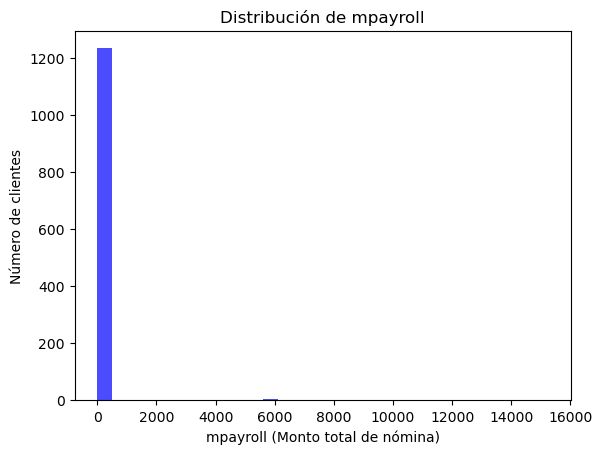

In [105]:
import matplotlib.pyplot as plt

# Histograma de 'mpayroll'
plt.hist(clus0['mpayroll'], bins=30, alpha=0.7, color='blue')
plt.title('Distribución de mpayroll')
plt.xlabel('mpayroll (Monto total de nómina)')
plt.ylabel('Número de clientes')
plt.show()


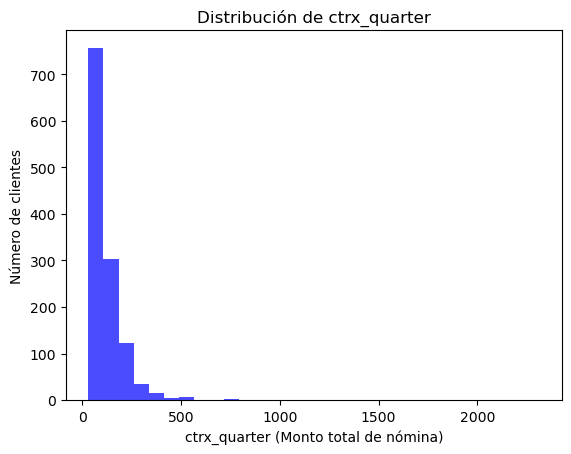

In [135]:
import matplotlib.pyplot as plt

# Histograma de 'mpayroll'
plt.hist(clus0['ctrx_quarter'], bins=30, alpha=0.7, color='blue')
plt.title('Distribución de ctrx_quarter')
plt.xlabel('ctrx_quarter (Monto total de nómina)')
plt.ylabel('Número de clientes')
plt.show()

In [129]:
group=clus0.groupby("numero_de_cliente")
group

In [131]:
clus0

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,cliente_antiguedad_5,cliente_antiguedad_6,lag_1_ctrx_quarter,delta_1_ctrx_quarter,lag_2_ctrx_quarter,ctrx_quarter_media_3,ctrx_quarter_max_3,ctrx_quarter_min_3,payroll_per_trx,cluster
346,249458924,202104,1,0,0,57,128,2441.27,16046.58,2666.93,...,3,6,51.0,3.0,52.0,50.250000,54.0,44.0,0.0,0
370,249494150,202104,1,0,0,53,180,-1352.42,-35612.83,2550.03,...,3,8,80.0,-1.0,82.0,82.750000,90.0,79.0,0.0,0
1916,250776861,202104,1,0,0,65,323,398.71,19308.91,162.35,...,4,10,69.0,-17.0,76.0,66.250000,76.0,52.0,0.0,0
2892,251566590,202104,1,0,0,82,288,16882.69,206301.49,2546.84,...,4,10,87.0,15.0,85.0,89.000000,102.0,82.0,0.0,0
3018,251679187,202104,1,0,0,58,323,5215.19,24715.14,2782.56,...,4,10,198.0,-9.0,197.0,192.500000,198.0,186.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977544,1550094443,202104,1,0,0,41,7,1915.86,15679.32,1114.10,...,1,1,50.0,27.0,35.0,49.000000,77.0,34.0,0.0,0
978143,1556412258,202104,1,0,0,27,8,547.26,4121.75,498.27,...,1,1,35.0,7.0,21.0,26.500000,42.0,8.0,0.0,0
978960,1558741624,202104,1,0,0,65,6,1619.97,17000.86,227.87,...,1,1,58.0,22.0,25.0,44.000000,80.0,13.0,0.0,0
979170,1559354136,202104,1,0,0,65,5,248.03,2939.29,8.69,...,1,1,82.0,-18.0,59.0,58.750000,82.0,30.0,0.0,0


In [117]:
clus0.loc[clus0['mpayroll']!=0]

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,cliente_antiguedad_5,cliente_antiguedad_6,lag_1_ctrx_quarter,delta_1_ctrx_quarter,lag_2_ctrx_quarter,ctrx_quarter_media_3,ctrx_quarter_max_3,ctrx_quarter_min_3,payroll_per_trx,cluster
54218,290559597,202104,1,0,0,52,264,6169.00,29443.47,4923.38,...,4,10,44.0,-2.0,41.0,43.25,46.0,41.0,4511.355000,0
152208,442237096,202104,1,0,0,69,200,1821.10,-1652.76,2078.32,...,4,8,38.0,6.0,34.0,35.00,44.0,24.0,1087.957500,0
242957,516798890,202104,1,0,0,72,71,2591.00,3126.22,2941.15,...,2,3,53.0,-4.0,60.0,53.00,60.0,49.0,17.595000,0
347020,611233748,202104,1,0,0,39,90,658.28,7365.07,618.75,...,2,4,59.0,-4.0,58.0,56.25,59.0,53.0,293.250000,0
354314,617884040,202104,1,0,0,56,126,1054.97,669.14,176.87,...,2,5,45.0,6.0,51.0,50.00,53.0,45.0,126.035000,0
362042,623362758,202104,1,0,0,39,191,-1087.84,-5258.38,1707.89,...,4,8,229.0,4.0,240.0,223.25,240.0,191.0,3012.360000,0
368988,628843081,202104,1,0,0,64,192,3625.25,36606.83,494.34,...,4,8,57.0,8.0,60.0,63.50,72.0,57.0,2011.695000,0
491944,733691641,202104,1,0,0,43,166,278.93,3028.02,384.83,...,3,7,32.0,11.0,18.0,28.00,43.0,18.0,1066.255000,0
579845,832691584,202104,1,0,0,63,150,2369.20,8213.95,2425.57,...,3,7,42.0,6.0,31.0,37.25,48.0,28.0,3812.250000,0
629423,878315336,202104,1,0,0,52,132,36.85,14121.82,0.00,...,3,6,83.0,-28.0,117.0,94.00,121.0,55.0,2932.500000,0


In [121]:
clus0.loc[clus0['cpayroll_trx']!=0]

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,cliente_antiguedad_5,cliente_antiguedad_6,lag_1_ctrx_quarter,delta_1_ctrx_quarter,lag_2_ctrx_quarter,ctrx_quarter_media_3,ctrx_quarter_max_3,ctrx_quarter_min_3,payroll_per_trx,cluster
54218,290559597,202104,1,0,0,52,264,6169.00,29443.47,4923.38,...,4,10,44.0,-2.0,41.0,43.25,46.0,41.0,4511.355000,0
70807,303717022,202104,1,0,0,50,323,4424.55,60229.77,2275.73,...,4,10,149.0,2.0,163.0,156.50,163.0,149.0,0.000000,0
86926,315791190,202104,1,0,0,54,270,-8074.95,-14496.00,1561.67,...,4,10,150.0,13.0,153.0,153.50,163.0,148.0,0.000000,0
152208,442237096,202104,1,0,0,69,200,1821.10,-1652.76,2078.32,...,4,8,38.0,6.0,34.0,35.00,44.0,24.0,1087.957500,0
180942,471063191,202104,1,0,0,42,244,-9159.30,91014.30,1805.56,...,4,9,280.0,32.0,242.0,270.25,312.0,242.0,0.000000,0
242957,516798890,202104,1,0,0,72,71,2591.00,3126.22,2941.15,...,2,3,53.0,-4.0,60.0,53.00,60.0,49.0,17.595000,0
312536,589330184,202104,1,0,0,49,22,-3529.77,-47403.22,635.64,...,1,1,214.0,22.0,214.0,216.25,236.0,201.0,0.000000,0
347020,611233748,202104,1,0,0,39,90,658.28,7365.07,618.75,...,2,4,59.0,-4.0,58.0,56.25,59.0,53.0,293.250000,0
354314,617884040,202104,1,0,0,56,126,1054.97,669.14,176.87,...,2,5,45.0,6.0,51.0,50.00,53.0,45.0,126.035000,0
362042,623362758,202104,1,0,0,39,191,-1087.84,-5258.38,1707.89,...,4,8,229.0,4.0,240.0,223.25,240.0,191.0,3012.360000,0


In [137]:
clus0.groupby('numero_de_cliente')[['ctrx_quarter',"foto_mes"]].sum()

,ctrx_quarter,foto_mes
numero_de_cliente,,
249458924,54,202104
249494150,79,202104
250776861,52,202104
251566590,102,202104
251679187,189,202104
...,...,...
1550094443,77,202104
1556412258,42,202104
1558741624,80,202104


In [113]:
clus0.groupby('numero_de_cliente')[['mpayroll',"foto_mes"]].sum()

,mpayroll,foto_mes
numero_de_cliente,,
249458924,0.0,202104
249494150,0.0,202104
250776861,0.0,202104
251566590,0.0,202104
251679187,0.0,202104
...,...,...
1550094443,0.0,202104
1556412258,0.0,202104
1558741624,0.0,202104


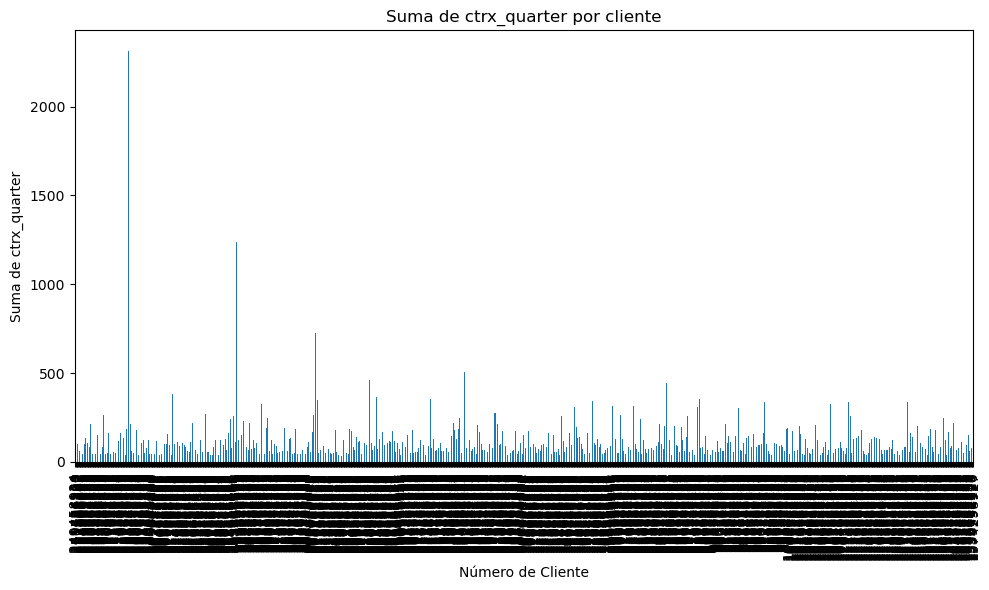

In [139]:
import matplotlib.pyplot as plt

# Agrupar por 'numero_de_cliente' y sumar 'ctrx_quarter' y 'foto_mes'
agrupado = clus0.groupby('numero_de_cliente')[['ctrx_quarter', 'foto_mes']].sum()

# Gráfica de barras para 'ctrx_quarter'
agrupado['ctrx_quarter'].plot(kind='bar', figsize=(10, 6))

plt.title('Suma de ctrx_quarter por cliente')
plt.xlabel('Número de Cliente')
plt.ylabel('Suma de ctrx_quarter')
plt.xticks(rotation=90)  # Rotar las etiquetas de los clientes si hay muchos
plt.tight_layout()
plt.show()


In [119]:
clus0.groupby('numero_de_cliente')[['cpayroll_trx',"foto_mes"]].sum()

,cpayroll_trx,foto_mes
numero_de_cliente,,
249458924,0,202104
249494150,0,202104
250776861,0,202104
251566590,0,202104
251679187,0,202104
...,...,...
1550094443,0,202104
1556412258,0,202104
1558741624,0,202104


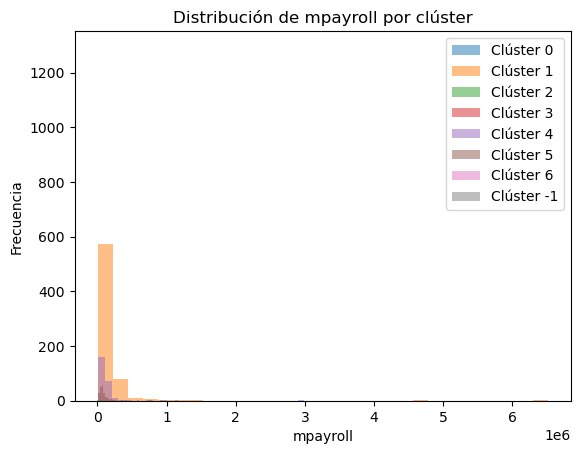

In [89]:
# Histograma de 'mpayroll' separado por clúster
for cluster in Xtrain_rf['cluster'].unique():
    subset = Xtrain_rf[Xtrain_rf['cluster'] == cluster]
    plt.hist(subset['mpayroll'], bins=30, alpha=0.5, label=f'Clúster {cluster}')

plt.legend()
plt.title('Distribución de mpayroll por clúster')
plt.xlabel('mpayroll')
plt.ylabel('Frecuencia')
plt.show()


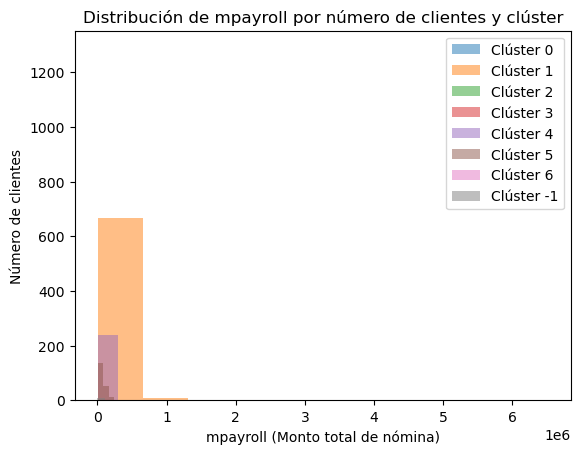

In [95]:
# Histograma de 'mpayroll' separado por clúster, representando número de clientes
for cluster in Xtrain_rf['cluster'].unique():
    subset = Xtrain_rf[Xtrain_rf['cluster'] == cluster]
    plt.hist(subset['mpayroll'], bins=10, alpha=0.5, label=f'Clúster {cluster}')

plt.legend()
plt.title('Distribución de mpayroll por número de clientes y clúster')
plt.xlabel('mpayroll (Monto total de nómina)')
plt.ylabel('Número de clientes')
plt.show()


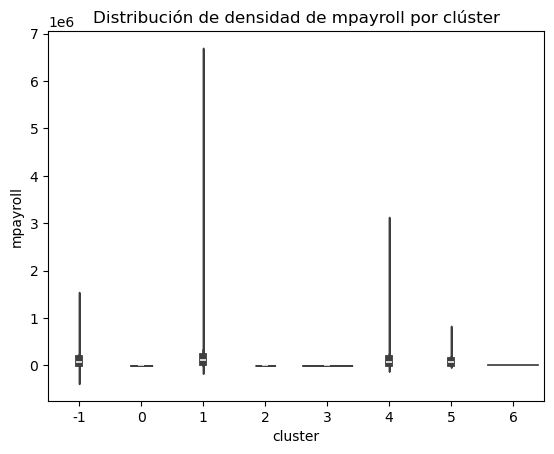

In [97]:
# Crear el violinplot para 'mpayroll' agrupado por clúster
sns.violinplot(x='cluster', y='mpayroll', data=Xtrain_rf)
plt.title('Distribución de densidad de mpayroll por clúster')
plt.show()


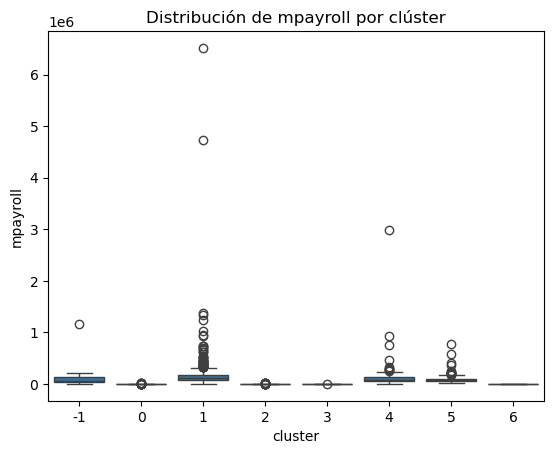

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear el boxplot para 'mpayroll' agrupado por clúster
sns.boxplot(x='cluster', y='mpayroll', data=Xtrain_rf)
plt.title('Distribución de mpayroll por clúster')
plt.show()


In [149]:
clus0

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,cliente_antiguedad_5,cliente_antiguedad_6,lag_1_ctrx_quarter,delta_1_ctrx_quarter,lag_2_ctrx_quarter,ctrx_quarter_media_3,ctrx_quarter_max_3,ctrx_quarter_min_3,payroll_per_trx,cluster
346,249458924,202104,1,0,0,57,128,2441.27,16046.58,2666.93,...,3,6,51.0,3.0,52.0,50.250000,54.0,44.0,0.0,0
370,249494150,202104,1,0,0,53,180,-1352.42,-35612.83,2550.03,...,3,8,80.0,-1.0,82.0,82.750000,90.0,79.0,0.0,0
1916,250776861,202104,1,0,0,65,323,398.71,19308.91,162.35,...,4,10,69.0,-17.0,76.0,66.250000,76.0,52.0,0.0,0
2892,251566590,202104,1,0,0,82,288,16882.69,206301.49,2546.84,...,4,10,87.0,15.0,85.0,89.000000,102.0,82.0,0.0,0
3018,251679187,202104,1,0,0,58,323,5215.19,24715.14,2782.56,...,4,10,198.0,-9.0,197.0,192.500000,198.0,186.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977544,1550094443,202104,1,0,0,41,7,1915.86,15679.32,1114.10,...,1,1,50.0,27.0,35.0,49.000000,77.0,34.0,0.0,0
978143,1556412258,202104,1,0,0,27,8,547.26,4121.75,498.27,...,1,1,35.0,7.0,21.0,26.500000,42.0,8.0,0.0,0
978960,1558741624,202104,1,0,0,65,6,1619.97,17000.86,227.87,...,1,1,58.0,22.0,25.0,44.000000,80.0,13.0,0.0,0
979170,1559354136,202104,1,0,0,65,5,248.03,2939.29,8.69,...,1,1,82.0,-18.0,59.0,58.750000,82.0,30.0,0.0,0


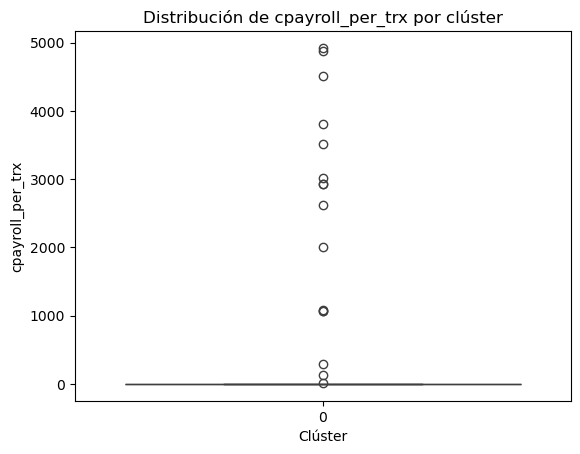

In [151]:
sns.boxplot(x='cluster', y='payroll_per_trx', data=clus0)
plt.title('Distribución de cpayroll_per_trx por clúster')
plt.xlabel('Clúster')
plt.ylabel('cpayroll_per_trx')
plt.show()

In [141]:

import seaborn as sns
import matplotlib.pyplot as plt

# Crear el boxplot para 'mpayroll' agrupado por clúster
# sns.boxplot(x='payroll_trx', y='', data=clus0)
plt.title('Distribución de cpayroll_trx por clúster')
plt.show()


ValueError: Could not interpret value `payroll_trx` for `y`. An entry with this name does not appear in `data`.

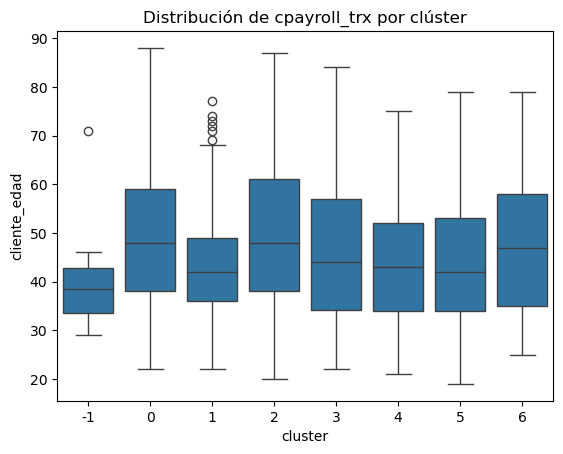

In [103]:

import seaborn as sns
import matplotlib.pyplot as plt

# Crear el boxplot para 'mpayroll' agrupado por clúster
sns.boxplot(x='cluster', y='cliente_edad', data=Xtrain_rf)
plt.title('Distribución de cpayroll_trx por clúster')
plt.show()

In [64]:
for cluster, features in important_features_by_cluster.items():
  print(f"Cluster {cluster} vs. Resto:")
  for feature in features[:5]:
    print(f"  - {feature}")


Cluster 0 vs. Resto:
  - mpayroll
  - payroll_per_trx
  - ctrx_quarter
  - cpayroll_trx
  - lag_1_ctrx_quarter
Cluster 1 vs. Resto:
  - mpayroll
  - payroll_per_trx
  - lag_2_ctrx_quarter
  - cpayroll_trx
  - ctrx_quarter_media_3
Cluster 2 vs. Resto:
  - ctrx_quarter
  - lag_1_ctrx_quarter
  - ctrx_quarter_min_3
  - lag_2_ctrx_quarter
  - ctrx_quarter_media_3
Cluster 3 vs. Resto:
  - ctarjeta_visa
  - lag_1_ctrx_quarter
  - ctrx_quarter
  - mcuentas_saldo
  - mcuenta_corriente
Cluster 4 vs. Resto:
  - ctrx_quarter_media_3
  - mpayroll
  - lag_2_ctrx_quarter
  - payroll_per_trx
  - ctrx_quarter_min_3
Cluster 5 vs. Resto:
  - mpayroll
  - payroll_per_trx
  - cpayroll_trx
  - ctarjeta_visa_transacciones
  - lag_2_ctrx_quarter
Cluster 6 vs. Resto:
  - Visa_Finiciomora
  - Visa_mpagominimo
  - Visa_status
  - tconsumo_total
  - Visa_msaldototal
Cluster -1 vs. Resto:
  - cliente_antiguedad_3
  - mcuentas_saldo
  - Visa_mpagospesos
  - mtransferencias_recibidas
  - lag_1_ctrx_quarter


## Análisis cluster 0

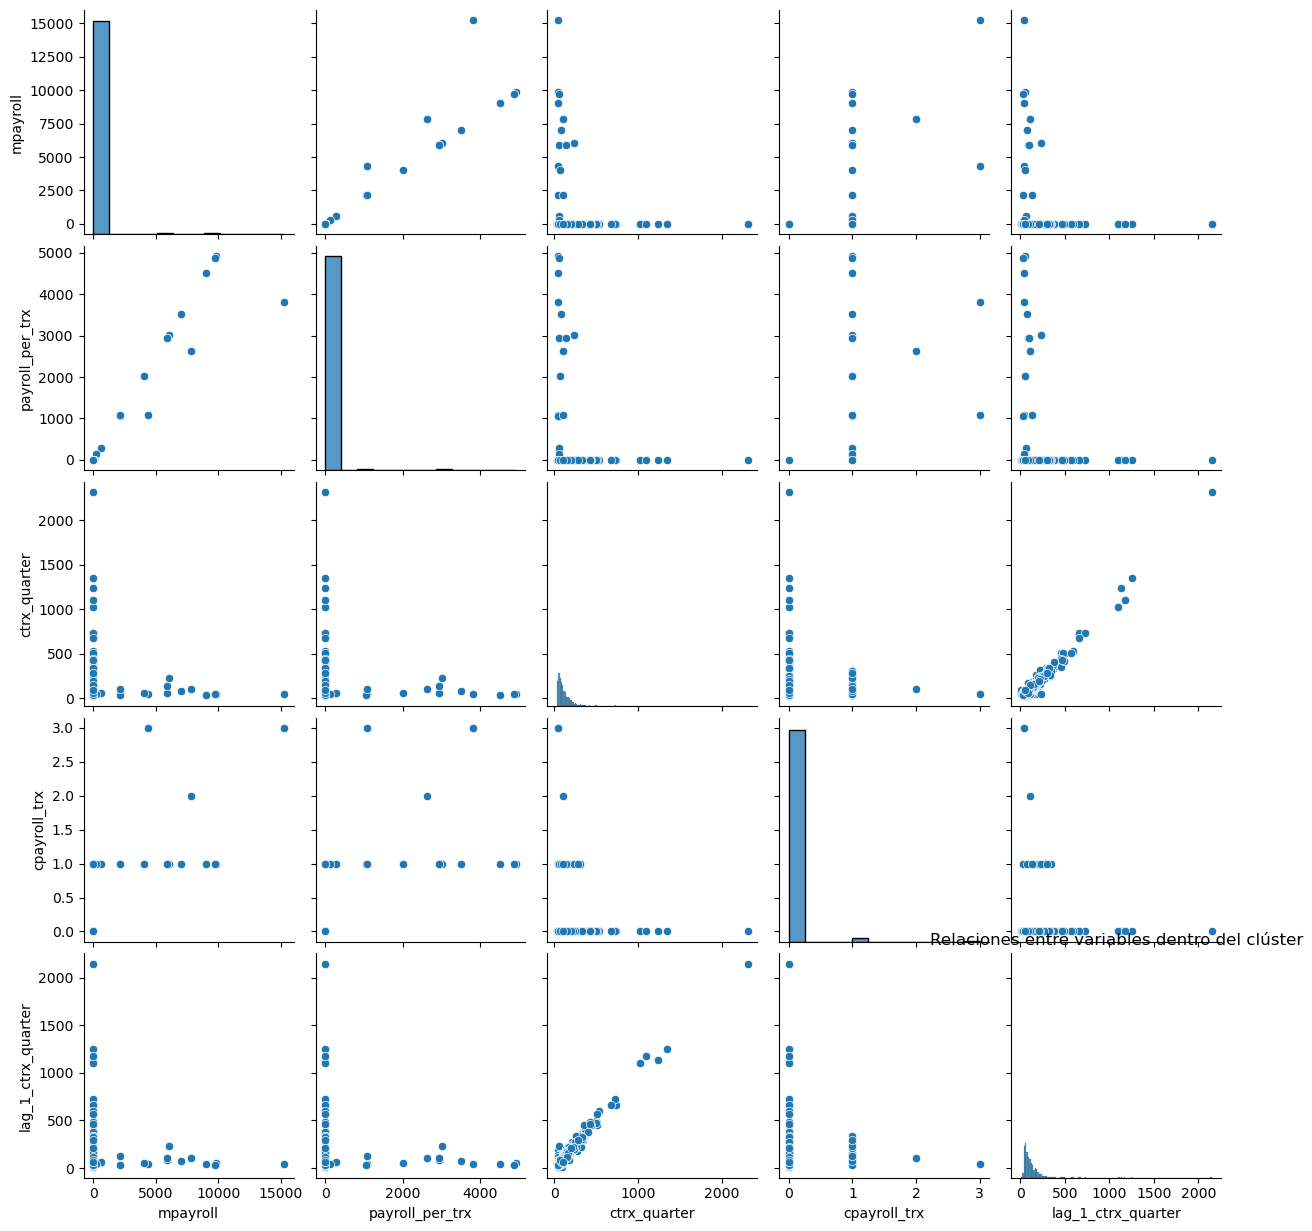

In [71]:
sns.pairplot(clus0[['mpayroll', 'payroll_per_trx', 'ctrx_quarter', 'cpayroll_trx', 'lag_1_ctrx_quarter']])
plt.title('Relaciones entre variables dentro del clúster')
plt.show()


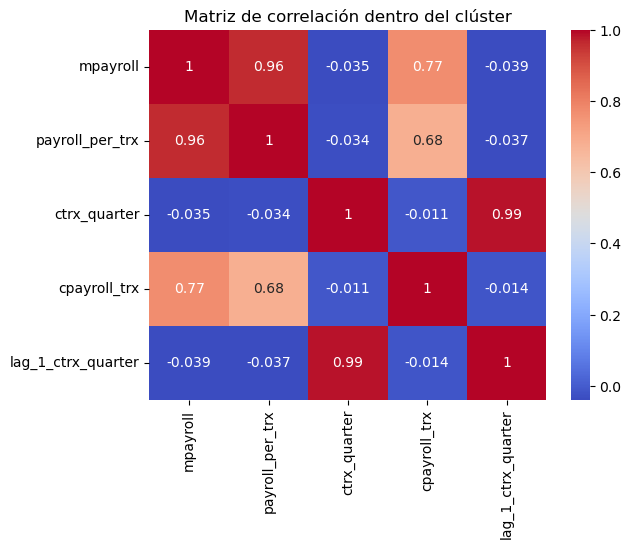

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar solo las columnas numéricas
numeric_df = clus0[['mpayroll', 'payroll_per_trx', 'ctrx_quarter', 'cpayroll_trx', 'lag_1_ctrx_quarter']].select_dtypes(include='number')

# Calcular la matriz de correlación
corr_matrix = numeric_df.corr()

# Graficar la matriz de correlación
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de correlación dentro del clúster')
plt.show()

In [ ]:
#ctrx_quarter=movimientos que realizo en los ultimos 90 dias
#mpayroll= monto que le acreditaron los acreditadores a sus empleados
#cpayroll_trx=cantidad de acreditaciones que le hicieron al cliente ese mes
#lag_1_ctrx_quarter=ctrx_quarter del mes anterior

In [85]:
clus0[['mpayroll', 'payroll_per_trx', 'ctrx_quarter', 'cpayroll_trx', 'lag_1_ctrx_quarter',"cliente_vip","cliente_edad"]].describe()

,mpayroll,payroll_per_trx,ctrx_quarter,cpayroll_trx,lag_1_ctrx_quarter,cliente_vip,cliente_edad
count,1249.000000,1249.000000,1249.000000,1249.000000,1244.000000,1249.000000,1249.000000
mean,72.096493,31.076553,119.644516,0.021617,120.275723,0.002402,49.371497
std,780.667826,328.700526,118.069793,0.179958,115.332185,0.048970,13.723507
min,0.000000,0.000000,31.000000,0.000000,6.000000,0.000000,22.000000
25%,0.000000,0.000000,59.000000,0.000000,60.000000,0.000000,38.000000
50%,0.000000,0.000000,92.000000,0.000000,93.000000,0.000000,48.000000
75%,0.000000,0.000000,142.000000,0.000000,144.250000,0.000000,59.000000
max,15249.000000,4924.710000,2314.000000,3.000000,2148.000000,1.000000,88.000000


Luego resta, analizar los estadísticos de los datos de cada cluster para las variables importantes, comparar sus distribuciones con histogramas, boxplots, pivot tables, etc.


Junto con el diccionaro de datos, de sentido a lo que ve a través del análisis multivariado de datos.

Obviamente, esto es apenas mas que una semilla. Agregue las variables históricas, juegue con los **rf** y genere una segmentación pro, que encante a Miranda


In [83]:
clus1[['mpayroll', 'payroll_per_trx', 'ctrx_quarter', 'cpayroll_trx', 'lag_1_ctrx_quarter']].describe()

,mpayroll,payroll_per_trx,ctrx_quarter,cpayroll_trx,lag_1_ctrx_quarter
count,6.790000e+02,6.790000e+02,679.000000,679.000000,676.000000
mean,1.699292e+05,7.049285e+04,169.469809,1.776141,169.727811
std,3.314490e+05,1.497054e+05,56.622529,2.166374,55.292889
min,7.038000e+03,2.989373e+03,67.000000,1.000000,84.000000
25%,8.125593e+04,3.095402e+04,130.000000,1.000000,130.750000
50%,1.183569e+05,4.876251e+04,158.000000,1.000000,156.000000
75%,1.760971e+05,7.456909e+04,193.000000,2.000000,198.000000
max,6.517532e+06,3.258766e+06,480.000000,35.000000,445.000000
